## RESULTS DATA ANALYSIS

Rows: 420

Trials per condition:
condition
StackedBar        140
ComparativeBar    140
Bar               140
Name: count, dtype: int64

Participants: 7
Trials per participant (min/median/max): 60 60.0 60


,condition,mean,ci_lo,ci_hi,n_trials,n_participants
0,Bar,1.676498,1.433912,1.884514,140,7
1,ComparativeBar,1.740218,1.435987,2.084520,140,7
2,StackedBar,2.264129,1.508180,3.433328,140,7


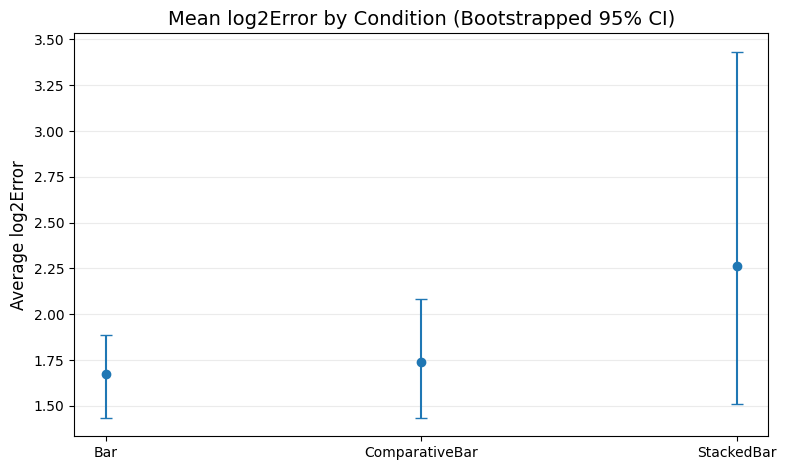

/var/folders/m2/rccp8lj55dv6dvg159hfj5fw0000gn/T/ipykernel_1642/1182258974.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=conds, showfliers=True)


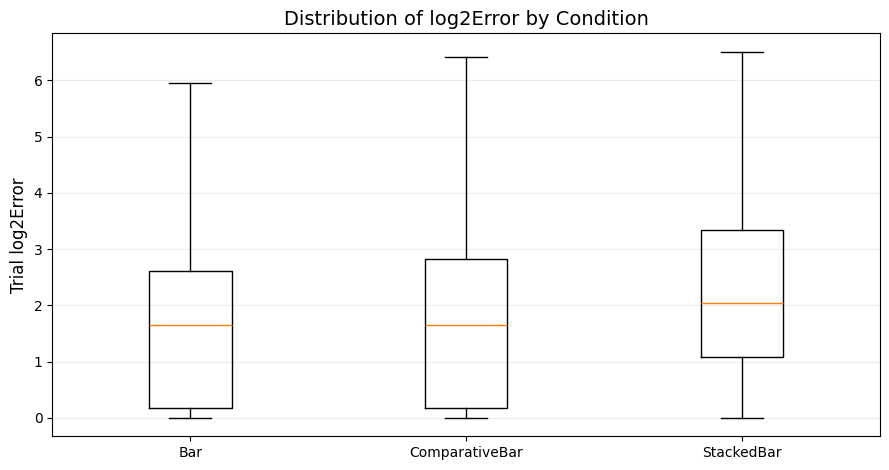

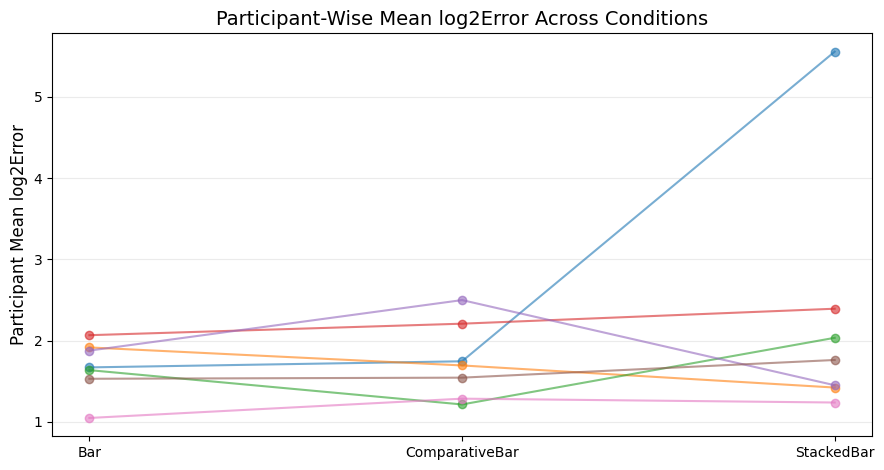

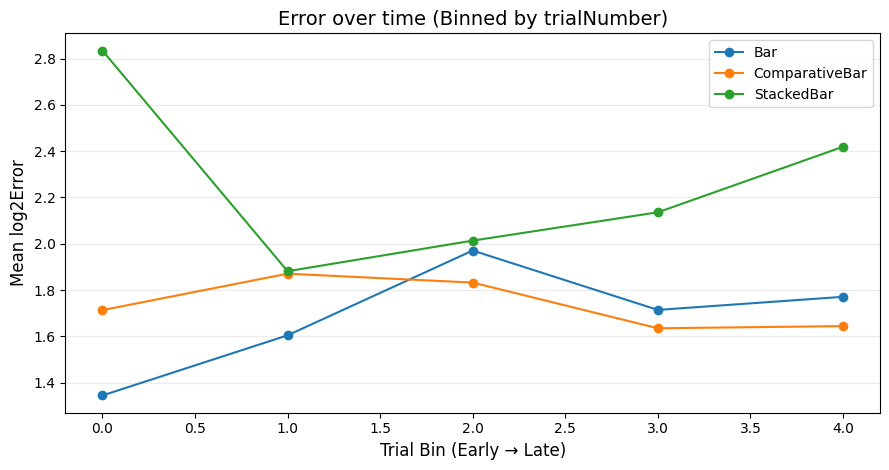

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4.8)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Load data
df = pd.read_csv("master_data.csv")

# Data cleaning
for col in ["trialNumber", "reportedPercent", "truePercent", "log2Error"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["participantId"] = df["participantId"].astype(str)
df["condition"] = df["condition"].astype(str)

# Drop rows missing fields
df = df.dropna(subset=["participantId", "trialNumber", "condition", "log2Error"])

print("Rows:", len(df))
print("\nTrials per condition:")
print(df["condition"].value_counts())

print("\nParticipants:", df["participantId"].nunique())
print("Trials per participant (min/median/max):",
      df.groupby("participantId").size().min(),
      df.groupby("participantId").size().median(),
      df.groupby("participantId").size().max())


def bootstrap_ci_mean(x, n_boot=5000, ci=0.95, seed=0):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return (np.nan, np.nan, np.nan)

    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    alpha = (1 - ci) / 2
    lo = np.quantile(boots, alpha)
    hi = np.quantile(boots, 1 - alpha)
    return (x.mean(), lo, hi)

def bootstrap_ci_participant_mean(df_sub, n_boot=5000, ci=0.95, seed=0):
    per_p = df_sub.groupby("participantId")["log2Error"].mean().dropna().to_numpy()
    return bootstrap_ci_mean(per_p, n_boot=n_boot, ci=ci, seed=seed)


# FIGURE 1: Main results (Cleveland–McGill style)
# Mean log2Error per condition + bootstrapped 95% CI, ordered best->worst
results = []
for cond, sub in df.groupby("condition"):
    mean_, lo, hi = bootstrap_ci_participant_mean(sub, n_boot=5000, ci=0.95, seed=42)
    n_trials = len(sub)
    n_participants = sub["participantId"].nunique()
    results.append((cond, mean_, lo, hi, n_trials, n_participants))

res = pd.DataFrame(results, columns=["condition", "mean", "ci_lo", "ci_hi", "n_trials", "n_participants"])
res = res.sort_values("mean", ascending=True).reset_index(drop=True)
display(res)

# Plot
x = np.arange(len(res))
y = res["mean"].to_numpy()
yerr = np.vstack([y - res["ci_lo"].to_numpy(), res["ci_hi"].to_numpy() - y])

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.xticks(x, res["condition"], rotation=0)
plt.ylabel("Average log2Error")
plt.title("Mean log2Error by Condition (Bootstrapped 95% CI)")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


# FIGURE 2: Distribution of trial-level log2Error by condition (shows spread / outliers)
conds = res["condition"].tolist()

plt.figure(figsize=(9, 4.8))
data = [df.loc[df["condition"] == c, "log2Error"].dropna().to_numpy() for c in conds]
plt.boxplot(data, labels=conds, showfliers=True)
plt.ylabel("Trial log2Error")
plt.title("Distribution of log2Error by Condition")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

# FIGURE 3: Per-participant mean error
pp = df.groupby(["participantId", "condition"])["log2Error"].mean().reset_index()
pivot = pp.pivot(index="participantId", columns="condition", values="log2Error")

plt.figure(figsize=(9, 4.8))
for pid in pivot.index:
    ys = [pivot.loc[pid].get(c, np.nan) for c in conds]
    plt.plot(range(len(conds)), ys, marker="o", alpha=0.6)

plt.xticks(range(len(conds)), conds)
plt.ylabel("Participant Mean log2Error")
plt.title("Participant-Wise Mean log2Error Across Conditions")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


# FIGURE 4: Learning/fatigue over trial order
df2 = df.copy()
df2["trial_bin"] = pd.cut(df2["trialNumber"], bins=5, labels=False)

trend = (df2.groupby(["condition", "trial_bin"])["log2Error"]
         .mean()
         .reset_index()
         .sort_values(["condition", "trial_bin"]))

plt.figure(figsize=(9, 4.8))
for c in conds:
    sub = trend[trend["condition"] == c]
    plt.plot(sub["trial_bin"], sub["log2Error"], marker="o", label=c)

plt.xlabel("Trial Bin (Early → Late)")
plt.ylabel("Mean log2Error")
plt.title("Error over time (Binned by trialNumber)")
plt.grid(True, axis="y", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()
